<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/Qiskit_Runtime_Dynamic_Circuit__mkbahk_20241010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

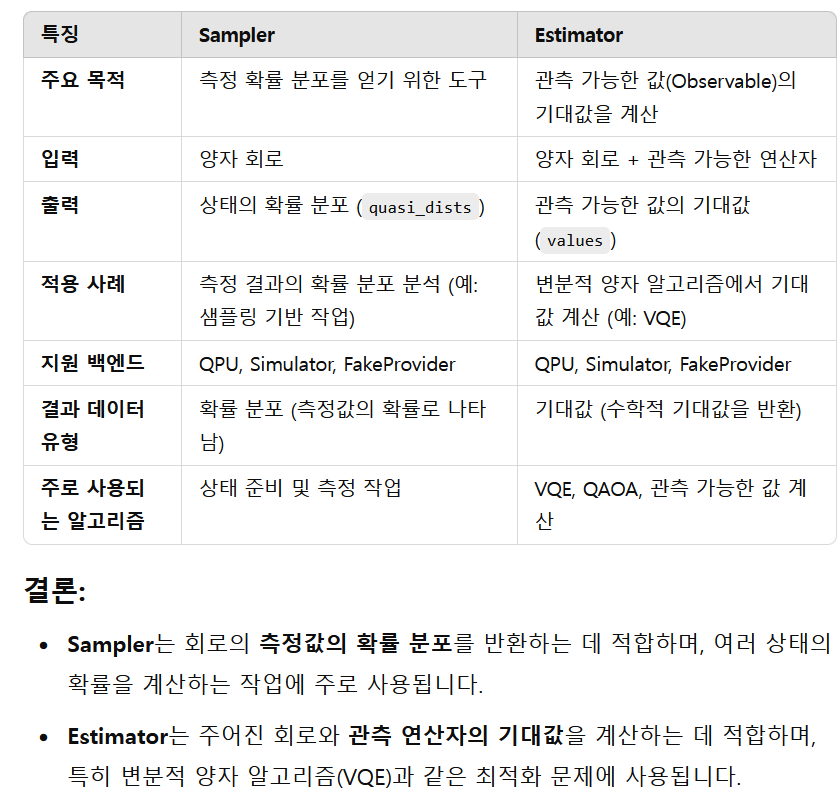

In [1]:
### Qiskit 설치: Windows, 클라우드 환경 ###
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-ibm-runtime==0.31.0
#%pip install qiskit-ibm-runtime==0.30.0
%pip install qiskit-transpiler-service==0.4.10
%pip install qiskit-aer==0.15.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 5.9 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=7cd546599df5051ccd59d1724072d6d4e2e58c56d688973567bd95fb927dae8b
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
%pip show qiskit qiskit-ibm-runtime qiskit-transpiler-service qiskit-aer

Name: qiskit
Version: 1.2.4
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-aer, qiskit-ibm-runtime, qiskit-qasm3-import, qiskit-transpiler-service
---
Name: qiskit-ibm-runtime
Version: 0.31.0
Summary: IBM Quantum client for Qiskit Runtime.
Home-page: https://github.com/Qiskit/qiskit-ibm-runtime
Author: Qiskit Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: ibm-platform-services, numpy, pydantic, python-dateutil, qiskit, requests, requests-ntlm, urllib3, websocket-client
Required-by: 
---
Name: qiskit-transpiler-service


## Long-range CNOT gate teleportation using dynamic circcuits
#Step 1: Map the problem to circuits and operations

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr

In [4]:
def get_dynamic_CNOT_circuit(num_qubit):
  """
  (1) 1D chain of nearest neighbors
  (2) 0th qubit is the control, and the las qubit (num_qubit-1) is the target
  (3) The control qubit starts in the + state

  """
  num_ancilla = num_qubit - 2
  num_ancilla_pair = int(num_ancilla / 2)

  qr = QuantumRegister(num_qubit)
  cr1 = ClassicalRegister(num_ancilla_pair, name="cr1") # The parity-controlled X gate
  cr2 = ClassicalRegister(num_ancilla - num_ancilla_pair, name="cr2") # The parity-controlled Z gate
  cr3 = ClassicalRegister(2, name="cr3") # for the final measurements on the control and target qubits

  qc = QuantumCircuit(qr, cr1, cr2, cr3)

  # Initialize the control qubit
  qc.h(0)
  qc.barrier()

  # Entanble the control qubit and the first ancilla qubit
  qc.cx(0, 1)

  # create Bell pairs on ancilla qubits
  # The first ancilla qubit in index 1
  for i in range(num_ancilla_pair):
    qc.h(2+2*i)
    qc.cx(2+2*i, 2+2*i+1)
  ###for

  # Prepare Bell pairs on staggered ancilla and data qubits
  for i in range(num_ancilla_pair+1):
    qc.cx(1+2*i, 1+2*i+1)
  ###for
  for i in range(num_ancilla_pair+2):
    qc.h(2*i-1)
  ###for

  # Measurement on alternating ancilla qubits starting with the first on
  # Keep track of the parity for eventual conditional Z gate
  for i in range(1, num_ancilla_pair+2):
    qc.measure(2*i-1, cr2[i-1])
    if i == 1:
      parity_control = expr.lift(cr2[i-1])
    else:
      parity_control = expr.bit_xor(cr2[i-1], parity_control)
    ###if
  ###for

  # Measurement on alternating ancilla qubits starting with the first on
  # Keep track of the parity for eventual conditional Z gate
  for i in range(num_ancilla_pair):
    qc.measure(2*i+2, cr1[i])
    if i == 0:
      parity_target = expr.lift(cr1[i])
    else:
      parity_target = expr.bit_xor(cr1[i], parity_target)
    ###if
  ###for

  with qc.if_test(parity_control):
    qc.z(0)
  ###with

  with qc.if_test(parity_target):
    qc.x(-1)
  ###with

  return qc
###def

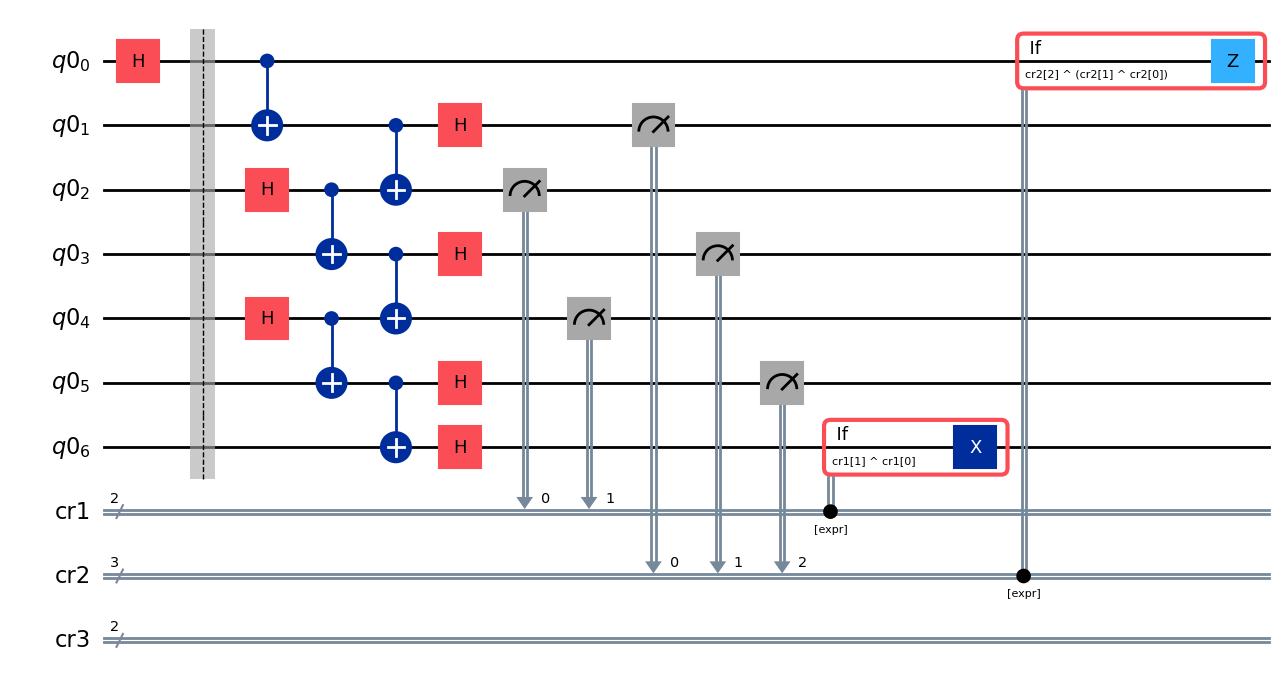

In [5]:
qc = get_dynamic_CNOT_circuit(num_qubit=7)
qc.draw(output='mpl')

In [6]:
max_num_qubit = 41

qc_list = []
num_qubit_list = list(range(7, max_num_qubit+1, 2))

for num_qubit in num_qubit_list:
  qc_list.append(get_dynamic_CNOT_circuit(num_qubit))
###for

# Step 2: Optimize the problem for quantum execution

In [27]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

backend_name = "ibm_kyiv"
service = QiskitRuntimeService(channel="ibm_quantum", token="ccf3ec2d41dd93ef2347ce310f7666e6ee9abe60c69140fe054e8c0ece30b5a1efa9398b33552751b5f4077fe4a91397fe8a302c796b8f6eb41ebecbd51904f7")
backend = service.backend(backend_name)

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_transpiled_list = pm.run(qc_list)

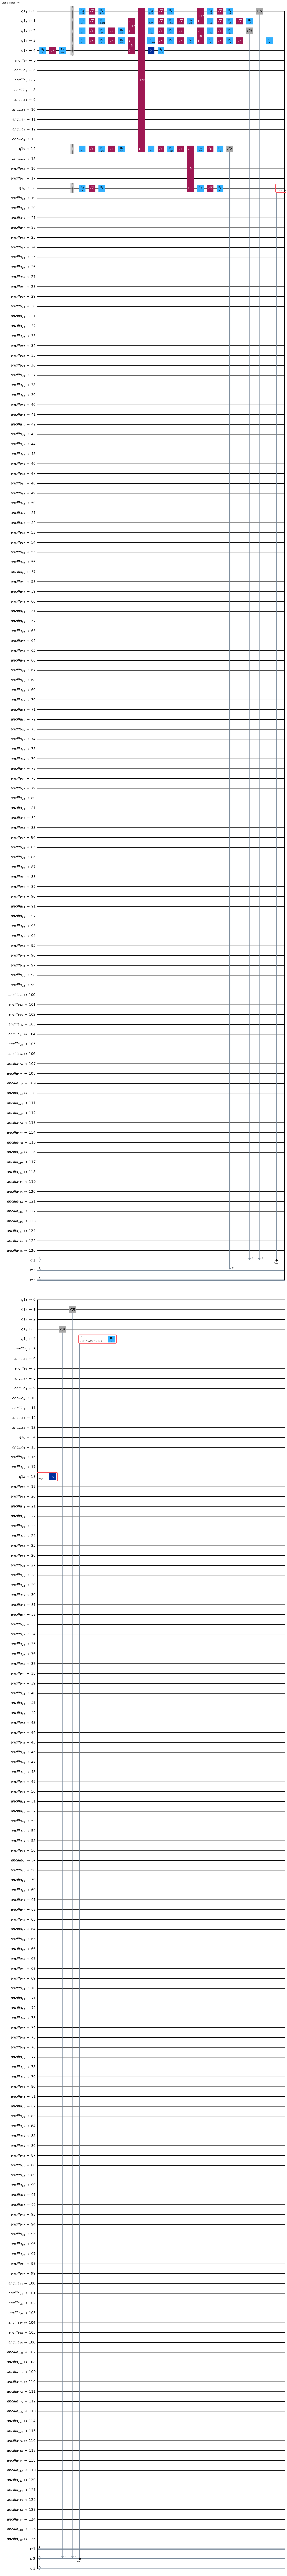

In [28]:
qc_transpiled_list[0].draw(output='mpl')

# Step 3: Execute the circuit

In [29]:
sampler = Sampler(backend)
job = sampler.run(qc_transpiled_list) #%pip install qiskit-ibm-runtime==0.30.0 에서는 에러 발생함
print(job.job_id())

cw8xgj2jyrs0008gxcj0


In [30]:
print(job.status())

ERROR


# Step 4: Post-processing (and plotting)

In [31]:
job_id = "cw8xb8nbhxtg008wprq0"
job = service.job(job_id)
result = job.result()

RuntimeJobFailureError: "Unable to retrieve job result. Error code 3211; Job not valid. Qubit(QuantumRegister(7, 'q1'), 6)"

In [26]:
import matplotlib.pyplot as plt

list_Bell =[]
list_Other = []

for i in range(0, len(qc_list)):
  data = result[i+1].data
  counts = data.cr3.get_counts()
  total_counts = data.cr3.num_shots

  prob_Bell = (counts['00'] + counts['11']) / total_counts

  list_Bell.append(prob_Bell)
  list_Other.append(1-prob_Bell)
###for

plt.plto(num_qubit_list, list_Bell, '--o', label='00 or 11')
plt.plot(num_qubit_list, list_other, '-,^', label='other')
plt.xlabel("Number of qubits")
plt.ylabel("Probability")
plt.legend()
plt.show()

NameError: name 'result' is not defined

In [ ]:
import matplotlib.pyplot as plt